In [1]:
import pandas as pd
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt

In [2]:


def extract_dl_ind(datalink_dict, key, figsize = [15,5], fontsize = 12, linewidth = 2, show_legend = True, show_grid = True):
    ""
    "Extract individual DataLink products and export them to an Astropy Table"
    ""
    dl_out  = datalink_dict[key][0].to_table()
    if 'time' in dl_out.keys():
        plot_e_phot(dl_out, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = fontsize, show_legend = show_legend, show_grid = show_grid, figsize = figsize)
    if 'wavelength' in dl_out.keys():
        if len(dl_out) == 343:  title = 'XP Sampled'
        if len(dl_out) == 2401: title = 'RVS'
        plot_sampled_spec(dl_out, color = 'blue', title = title, fontsize = fontsize, show_legend = False, show_grid = show_grid, linewidth = linewidth, legend = '', figsize = figsize)
    return dl_out


def plot_e_phot(inp_table, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = 12, show_legend = True, show_grid = True, figsize = [15,5]):
    ""
    "Epoch photometry plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    fig      = plt.figure(figsize=figsize)
    xlabel   = f'JD date [{inp_table["time"].unit}]'
    ylabel   = f'magnitude [{inp_table["mag"].unit}]'
    gbands   = ['G', 'RP', 'BP']
    colours  = iter(colours)

    plt.gca().invert_yaxis()
    for band in gbands:
        phot_set = inp_table[inp_table['band'] == band]
        plt.plot(phot_set['time'], phot_set['mag'], 'o', label = band, color = next(colours))
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    plt.show()


def plot_sampled_spec(inp_table, color = 'blue', title = '', fontsize = 14, show_legend = True, show_grid = True, linewidth = 2, legend = '', figsize = [12,4], show_plot = True):
    ""
    "RVS & XP sampled spectrum plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    if show_plot:
        fig      = plt.figure(figsize=figsize)
    xlabel   = f'Wavelength [{inp_table["wavelength"].unit}]'
    ylabel   = f'Flux [{inp_table["flux"].unit}]'
    plt.plot(inp_table['wavelength'], inp_table['flux'], '-', linewidth = linewidth, label = legend)
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    if show_plot:
        plt.show()


def make_canvas(title = '', xlabel = '', ylabel = '', show_grid = False, show_legend = False, fontsize = 12):
    ""
    "Create generic canvas for plots"
    ""
    plt.title(title,    fontsize = fontsize)
    plt.xlabel(xlabel,  fontsize = fontsize)
    plt.ylabel(ylabel , fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    if show_grid:
        plt.grid()
    if show_legend:
        plt.legend(fontsize = fontsize*0.75)


In [23]:
query = f"SELECT source_id, ra, dec, pmra, pmdec, parallax \
FROM gaiadr3.gaia_source \
WHERE has_epoch_photometry = 'True' \
AND source_id = 1561928427003019520"


job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results.to_pandas()

500 Error 500:
null


HTTPError: Error 500:
null

In [4]:
retrieval_type = 'EPOCH_PHOTOMETRY'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'


datalink = Gaia.load_data(ids=results['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]
dl_keys.sort()

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')


The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 1561928427003019520.xml


In [5]:
dl_key = 'EPOCH_PHOTOMETRY-Gaia DR3 1561928427003019520.xml'

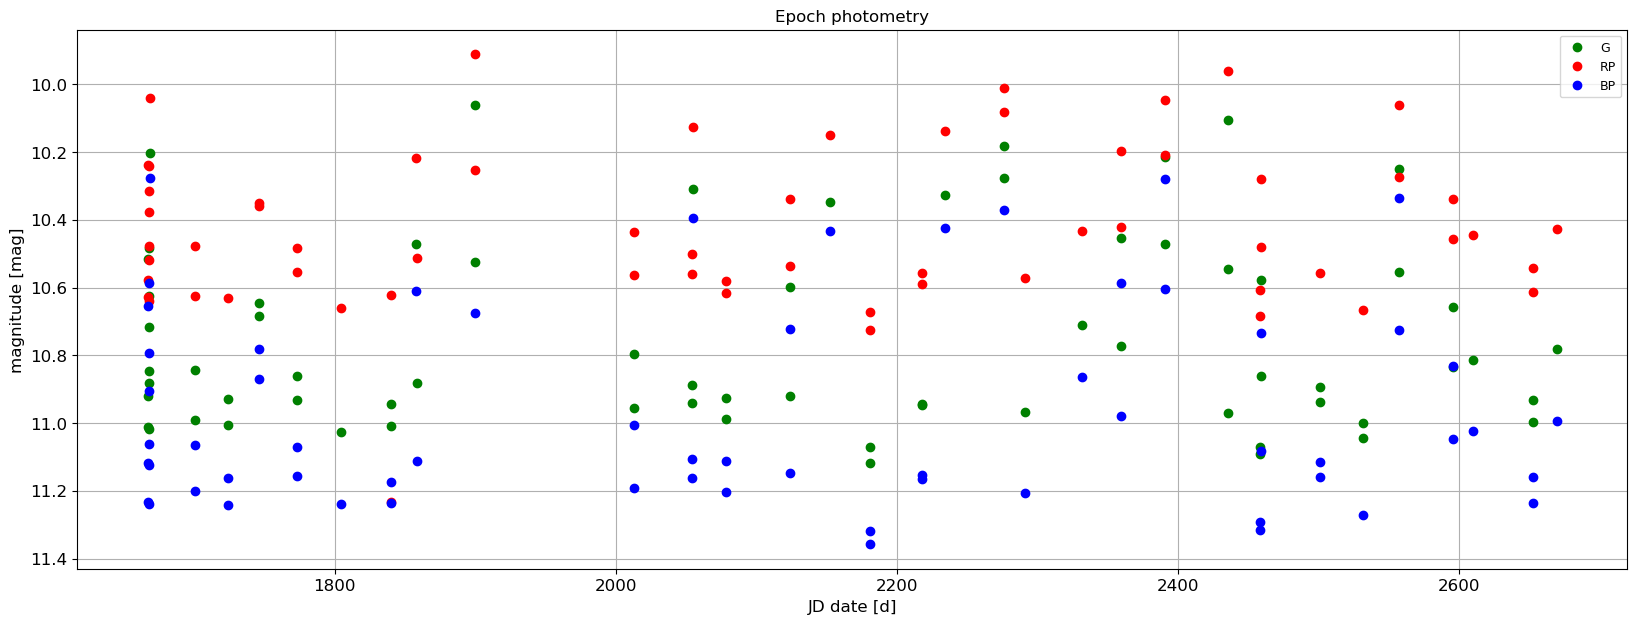

In [6]:
dl_out  = extract_dl_ind(datalink, dl_key, figsize=[20,7])   # Change the figsize to e.g. figsize=[20,7] to increase the size of the displayed image.

In [7]:
product  = datalink[dl_key][0]
prod_tab = product.to_table().to_pandas()

In [8]:
g_filter = prod_tab.where(prod_tab['band'] == 'G').dropna().reset_index(drop = True)
bp_filter = prod_tab.where(prod_tab['band'] == 'BP').dropna().reset_index(drop = True)
rp_filter = prod_tab.where(prod_tab['band'] == 'RP').dropna().reset_index(drop = True)

In [9]:
(bp_filter['time'] - bp_filter['time'][0]) * 24 * 3600

0     0.000000e+00
1     2.161335e+04
2     2.800729e+04
3     4.322673e+04
4     4.962188e+04
          ...     
56    8.020252e+07
57    8.145418e+07
58    8.509935e+07
59    8.510574e+07
60    8.658989e+07
Name: time, Length: 61, dtype: float64

In [24]:
t_g = g_filter['time'] - g_filter['time'][0]
t_bp = bp_filter['time'] - bp_filter['time'][0]
t_rp = rp_filter['time'] - rp_filter['time'][0]

In [25]:
import numpy as np

period = 0.46806 # period in days


phase_g  = np.array(t_g)/period - np.floor(np.array(t_g)/period)
phase_bp  = np.array(t_bp)/period - np.floor(np.array(t_bp)/period)
phase_rp  = np.array(t_rp)/period - np.floor(np.array(t_rp)/period)

g_mags = g_filter['mag']
bp_mags = bp_filter['mag']
rp_mags = rp_filter['mag']

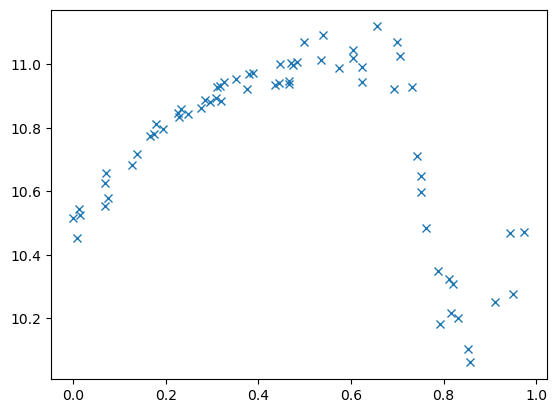

In [26]:
plt.plot(phase_g, g_mags, 'x')

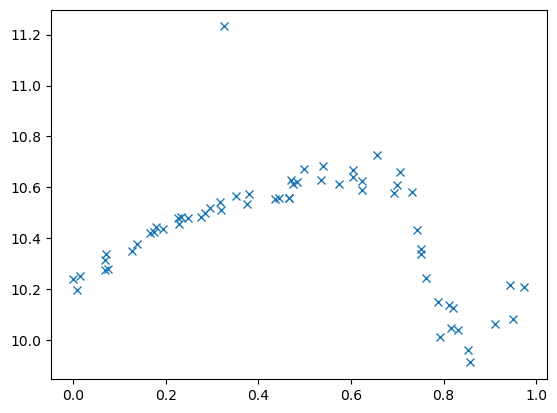

In [27]:
plt.plot(phase_rp, rp_mags, 'x')

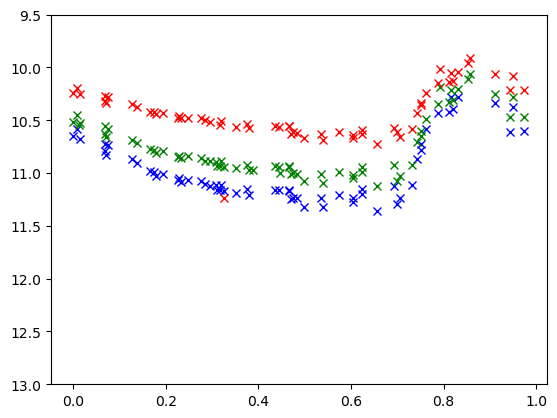

In [28]:
plt.plot(phase_bp, bp_mags, 'x', color = 'blue')
plt.plot(phase_g, g_mags, 'x', color = 'green')
plt.plot(phase_rp, rp_mags, 'x', color = 'red')
plt.ylim(9.5, 13)
plt.gca().invert_yaxis()

In [15]:
g_filter['Phase'] = phase_g

In [16]:
g_filter

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,Phase
0,1.561928e+18,1.495264e+16,G,1667.252478,10.515306,1.171721e+06,683.506827,1714.278564,False,False,1.0,3.753167e+17,0.000000
1,1.561928e+18,1.496648e+16,G,1667.502629,11.012224,7.414078e+05,562.798734,1317.358643,False,False,4097.0,3.753167e+17,0.532237
2,1.561928e+18,1.497057e+16,G,1667.576634,10.921110,8.063114e+05,855.024150,943.027588,False,False,4097.0,3.753167e+17,0.689694
3,1.561928e+18,1.498031e+16,G,1667.752761,10.625820,1.058324e+06,788.283572,1342.567505,False,False,4198401.0,3.753167e+17,0.064432
4,1.561928e+18,1.498440e+16,G,1667.826793,10.846144,8.639507e+05,662.510679,1304.055542,False,False,4097.0,3.753167e+17,0.221948
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.561928e+18,6.628197e+16,G,2595.522333,10.834418,8.733327e+05,643.979950,1356.148804,False,False,4194305.0,3.753167e+17,0.042245
63,1.561928e+18,6.708302e+16,G,2610.009243,10.813026,8.907104e+05,672.176656,1325.113525,False,False,4101.0,3.753167e+17,0.865457
64,1.561928e+18,6.941594e+16,G,2652.198613,10.931116,7.989145e+05,636.951685,1254.278076,False,False,4097.0,3.753167e+17,0.630075
65,1.561928e+18,6.942003e+16,G,2652.272592,10.996852,7.519795e+05,3670.627922,204.863983,False,False,4198401.0,3.753167e+17,0.787478


In [17]:
test = g_filter.sort_values(by = ['Phase'])

In [18]:
test

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,Phase
0,1.561928e+18,1.495264e+16,G,1667.252478,10.515306,1.171721e+06,683.506827,1714.278564,False,False,1.0,3.753167e+17,0.000000
28,1.561928e+18,3.636845e+16,G,2054.545727,10.940504,7.920362e+05,490.064761,1616.186768,False,False,4194305.0,3.753167e+17,0.028189
62,1.561928e+18,6.628197e+16,G,2595.522333,10.834418,8.733327e+05,643.979950,1356.148804,False,False,4194305.0,3.753167e+17,0.042245
14,1.561928e+18,1.932024e+16,G,1746.237809,10.646485,1.038372e+06,1324.685580,783.862854,False,False,4097.0,3.753167e+17,0.053897
45,1.561928e+18,5.321020e+16,G,2359.122727,10.772352,9.247112e+05,1350.251449,684.843689,False,False,4097.0,3.753167e+17,0.064359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,1.561928e+18,2.451534e+16,G,1840.193060,11.008229,7.441407e+05,759.896367,979.266113,False,False,4097.0,3.753167e+17,0.958686
24,1.561928e+18,2.781601e+16,G,1899.885404,10.525616,1.160647e+06,615.642548,1885.261719,False,False,8193.0,3.753167e+17,0.963672
35,1.561928e+18,4.335775e+16,G,2180.947288,11.070841,7.024418e+05,700.342656,1002.997375,False,False,4097.0,3.753167e+17,0.967681
13,1.561928e+18,1.809655e+16,G,1724.107458,11.004572,7.466513e+05,2042.480673,365.561005,False,False,4097.0,3.753167e+17,0.968044


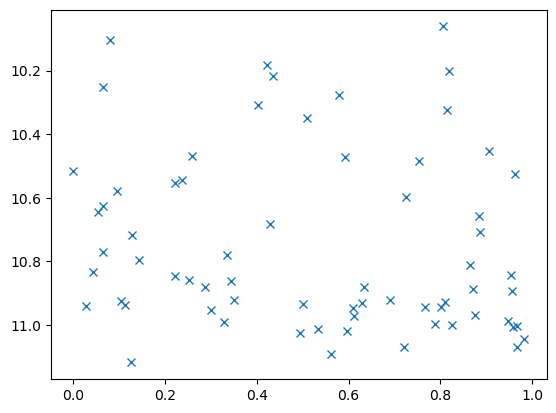

In [19]:
plt.plot(test['Phase'], test['mag'], 'x')
plt.gca().invert_yaxis()

In [20]:
g_filter

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,Phase
0,1.561928e+18,1.495264e+16,G,1667.252478,10.515306,1.171721e+06,683.506827,1714.278564,False,False,1.0,3.753167e+17,0.000000
1,1.561928e+18,1.496648e+16,G,1667.502629,11.012224,7.414078e+05,562.798734,1317.358643,False,False,4097.0,3.753167e+17,0.532237
2,1.561928e+18,1.497057e+16,G,1667.576634,10.921110,8.063114e+05,855.024150,943.027588,False,False,4097.0,3.753167e+17,0.689694
3,1.561928e+18,1.498031e+16,G,1667.752761,10.625820,1.058324e+06,788.283572,1342.567505,False,False,4198401.0,3.753167e+17,0.064432
4,1.561928e+18,1.498440e+16,G,1667.826793,10.846144,8.639507e+05,662.510679,1304.055542,False,False,4097.0,3.753167e+17,0.221948
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.561928e+18,6.628197e+16,G,2595.522333,10.834418,8.733327e+05,643.979950,1356.148804,False,False,4194305.0,3.753167e+17,0.042245
63,1.561928e+18,6.708302e+16,G,2610.009243,10.813026,8.907104e+05,672.176656,1325.113525,False,False,4101.0,3.753167e+17,0.865457
64,1.561928e+18,6.941594e+16,G,2652.198613,10.931116,7.989145e+05,636.951685,1254.278076,False,False,4097.0,3.753167e+17,0.630075
65,1.561928e+18,6.942003e+16,G,2652.272592,10.996852,7.519795e+05,3670.627922,204.863983,False,False,4198401.0,3.753167e+17,0.787478
